In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
sns.set_style("whitegrid")

In [3]:
%matplotlib inline

In [4]:
summary = pd.read_csv("atussum_2013.dat")
summary.info()

def activity_by_age(df, activity_code, subsample=True):
    activity_col = "t{}".format(activity_code)
    df = df[['TUFINLWGT', 'TEAGE', activity_col]]
    df = df.rename(columns={"TUFINLWGT": "weight", "TEAGE": "age", activity_col: "minutes"})
    if subsample:
        df = df[df.age % 5 == 0]
    df['weighted_minutes'] = df.weight * df.minutes
    df = df.groupby("age").sum()
    df['mean_minutes'] = df.weighted_minutes / df.weight
    df = df[['mean_minutes']]
    return df

def linear_least_squares(df, fn):
    values = df.index.map(fn)
    diffs = df.mean_minutes - values
    diffs_squared = diffs ** 2
    return diffs_squared.sum() / (2 * len(diffs)) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


In [5]:
sleep_data = summary[['TUFINLWGT', 'TEAGE', 'TESEX', 't010101']]
sleep_data = sleep_data.rename(columns={"TUFINLWGT": "weight", "TEAGE": "age", "TESEX": "sex", "t010101": "minutes"})
sleep_data['weighted_minutes'] = sleep_data.weight * sleep_data.minutes
sleep_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Data columns (total 5 columns):
weight              11385 non-null float64
age                 11385 non-null int64
sex                 11385 non-null int64
minutes             11385 non-null int64
weighted_minutes    11385 non-null float64
dtypes: float64(2), int64(3)
memory usage: 533.7 KB


In [6]:
sleep_by_age = sleep_data.groupby("age").sum()
sleep_by_age.head()

,weight,sex,minutes,weighted_minutes
age,,,,
15,1.168895e+09,159,62992,6.645155e+11
16,1.807565e+09,243,96196,1.013404e+12
17,1.929189e+09,246,96861,1.094304e+12
18,1.419704e+09,165,64722,8.498931e+11
19,1.307960e+09,130,50557,7.508169e+11


In [7]:
sleep_by_age['mean_minutes'] = sleep_by_age.weighted_minutes / sleep_by_age.weight
sleep_by_age.head()

,weight,sex,minutes,weighted_minutes,mean_minutes
age,,,,,
15,1.168895e+09,159,62992,6.645155e+11,568.498993
16,1.807565e+09,243,96196,1.013404e+12,560.646005
17,1.929189e+09,246,96861,1.094304e+12,567.235373
18,1.419704e+09,165,64722,8.498931e+11,598.641088
19,1.307960e+09,130,50557,7.508169e+11,574.036484


In [8]:
sleep_by_age.loc[38].mean_minutes / 60

8.5302245832886427

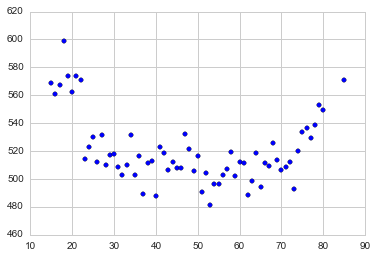

In [9]:
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)

In [10]:
regression = linear_model.LinearRegression()
regression.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), sleep_by_age.mean_minutes.values)
print(regression.coef_, regression.intercept_)

[-0.3727603] 538.764180347


275.926659317


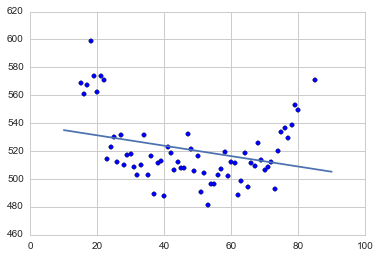

In [11]:
fn = lambda x: regression.predict(x)[0]
print(linear_least_squares(sleep_by_age, fn))
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, [fn(x) for x in xs])

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)
model.named_steps['linear'].coef_
print(model.named_steps)

{'linear': LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False), 'poly': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)}


97.2604515584


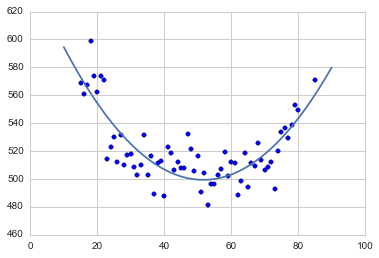

In [13]:
fn = lambda x: model.predict(x)[0]
print(linear_least_squares(sleep_by_age, fn))
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, [fn(x) for x in xs])

In [14]:
model.predict(38) / 60

array([ 8.49389415])

In [15]:
model.predict(50) / 60

array([ 8.32589668])

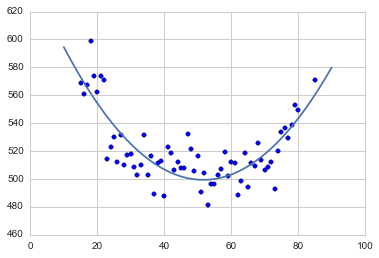

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)
model.named_steps['linear'].coef_
fn = lambda x: model.predict(x)[0]
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, [fn(x) for x in xs])

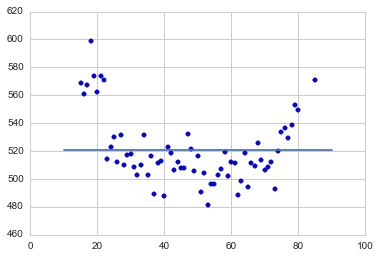

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=0)),
                  ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)
model.named_steps['linear'].coef_
fn = lambda x: model.predict(x)[0]
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, [fn(x) for x in xs])

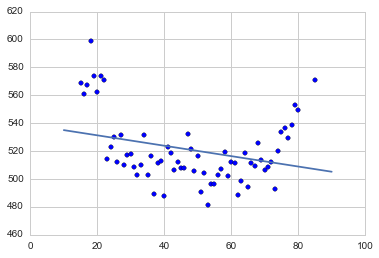

In [19]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)
model.named_steps['linear'].coef_
fn = lambda x: model.predict(x)[0]
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, [fn(x) for x in xs])

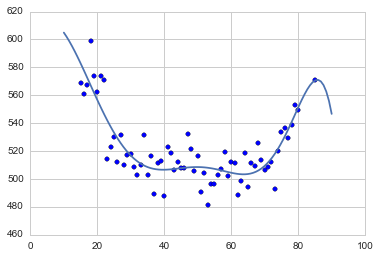

In [30]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=7)),
                  ('linear', Ridge())])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)
model.named_steps['linear'].coef_
fn = lambda x: model.predict(x)[0]
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, [fn(x) for x in xs])

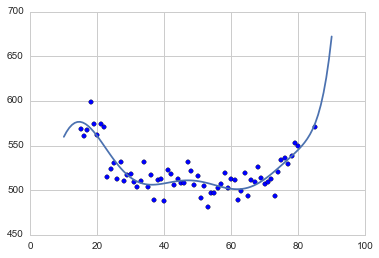

In [33]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
model = Pipeline([('poly', PolynomialFeatures(degree=8)),
                  ('linear', LinearRegression())])
model = model.fit(np.array(sleep_by_age.index.values).reshape((-1, 1)), 
                  sleep_by_age.mean_minutes.values)
model.named_steps['linear'].coef_
fn = lambda x: model.predict(x)[0]
plt.scatter(sleep_by_age.index, sleep_by_age.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, [fn(x) for x in xs])